In [3]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify
!pip install matplotib

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/pip-req-build-4dt40pbz
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/8_/mkx2sfs13pqgtr19k0_pc89h0000gn/T/pip-req-build-4dt40pbz
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement matplotib (from versions: none)
ERROR: No matching distribution found for matplotib


In [4]:
!pip install matplotlib

  Using cached matplotlib-3.10.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp311-cp311-macosx_10_9_universal2.whl.metadata (101 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pillow-11.1.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.1-cp311-cp311-macosx_11_0_arm64.whl (8.0 MB)
Using cached contourpy-1.3.1-cp311-cp311-macosx_11_0_arm64.whl (254 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.56.0-cp311-cp311-macosx_10_9_universal2.whl (2.8 MB)
Using cached kiwisolver-1.4.8-cp311-cp311-macosx_11_0_arm64.whl (65 kB)
Using cached pillow-11.1.0-cp311-cp311-macosx_11_0_arm64.whl (3.1 MB)
Using cached pyparsing-3.2.1-p

In [8]:
!pip install scipy

  Using cached scipy-1.15.2-cp311-cp311-macosx_14_0_arm64.whl.metadata (61 kB)
Using cached scipy-1.15.2-cp311-cp311-macosx_14_0_arm64.whl (22.4 MB)


In [9]:
!pip install tifffile

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
from PIL import Image

In [3]:
DATA_FOLDER = '/Users/andreafrasson/Desktop/sam2/FTW/'
TRAINING = os.path.join(DATA_FOLDER, 'training')

## TRAINING

In [4]:
# delete empty masks as they may cause issues later on during training
train_gt = os.listdir(os.path.join(TRAINING, 'gt'))

valid_instances = []
for gt in train_gt:
    img = Image.open(os.path.join(os.path.join(TRAINING, 'gt', gt)))
    fn = lambda x : 255 if x > 70 else 0
    img = img.convert('L').point(fn, mode = '1')
    if np.max(img) > 0:
        valid_instances.append(gt)

In [4]:
from datasets import Dataset

/Users/andreafrasson/Desktop/sam_ft/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data_dict = {}

for img in valid_instances:
    data_dict['img'] = data_dict.get('img', []) + [Image.open(os.path.join(TRAINING, 'img', img))]

    gt = Image.open(os.path.join(TRAINING, 'gt', img))
    fn = lambda x : 255 if x > 70 else 0
    gt = gt.convert('L').point(fn, mode = '1')
    data_dict['gt'] = data_dict.get('gt', []) + [gt]

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(data_dict)

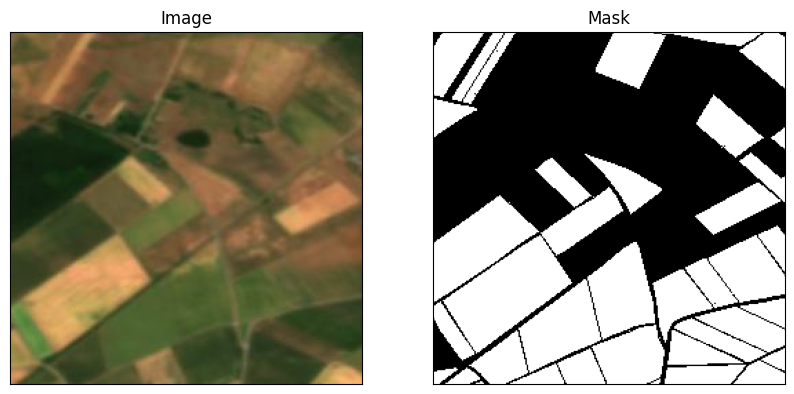

In [8]:
img_num = random.randint(0, len(valid_instances)-1)
example_image = dataset[img_num]["img"]
example_mask = dataset[img_num]["gt"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [7]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["img"]
    ground_truth_mask = np.array(item["gt"])

    # get bounding box prompt
    prompt = 'field'

    # prepare image and prompt for the model
    inputs = self.processor(image, input_text=prompt, return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [9]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [30]:
from SamDataset import SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

NameError: name 'dataset' is not defined

In [11]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

Keyword argument `input_text` is not a valid argument for this processor and will be ignored.


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
ground_truth_mask (256, 256)


/Users/andreafrasson/Desktop/sam_ft/.venv/lib/python3.11/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [13]:
# Load the model
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [14]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [15]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 40
if torch.cuda.is_available():
  device = "cuda" 
elif torch.backends.mps.is_available():
  device = torch.device("mps")
else: 
  device = "cpu"

model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1)).to(device)

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 0/1228 [00:00<?, ?it/s]/Users/andreafrasson/Desktop/sam_ft/.venv/lib/python3.11/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)
100%|██████████| 1228/1228 [26:27<00:00,  1.29s/it]


EPOCH: 0
Mean loss: 0.8967423691423397


100%|██████████| 1228/1228 [28:49<00:00,  1.41s/it]  


EPOCH: 1
Mean loss: 0.8142917764885806


100%|██████████| 1228/1228 [26:21<00:00,  1.29s/it]


EPOCH: 2
Mean loss: 0.7850576169085036


100%|██████████| 1228/1228 [26:21<00:00,  1.29s/it]


EPOCH: 3
Mean loss: 0.7671064562270424


100%|██████████| 1228/1228 [26:21<00:00,  1.29s/it]


EPOCH: 4
Mean loss: 0.7543187745473672


100%|██████████| 1228/1228 [26:20<00:00,  1.29s/it]


EPOCH: 5
Mean loss: 0.7434556474029436


100%|██████████| 1228/1228 [26:20<00:00,  1.29s/it]


EPOCH: 6
Mean loss: 0.7340719803245526


100%|██████████| 1228/1228 [26:20<00:00,  1.29s/it]


EPOCH: 7
Mean loss: 0.7254385797592056


100%|██████████| 1228/1228 [26:20<00:00,  1.29s/it]


EPOCH: 8
Mean loss: 0.7170611318771148


100%|██████████| 1228/1228 [26:18<00:00,  1.29s/it]


EPOCH: 9
Mean loss: 0.7088034369949409


100%|██████████| 1228/1228 [26:18<00:00,  1.29s/it]


EPOCH: 10
Mean loss: 0.7005878379416777


100%|██████████| 1228/1228 [26:18<00:00,  1.29s/it]


EPOCH: 11
Mean loss: 0.6958860959675685


100%|██████████| 1228/1228 [26:18<00:00,  1.29s/it]


EPOCH: 12
Mean loss: 0.6864793940237951


100%|██████████| 1228/1228 [26:18<00:00,  1.29s/it]


EPOCH: 13
Mean loss: 0.6821341465442693


100%|██████████| 1228/1228 [26:18<00:00,  1.29s/it]


EPOCH: 14
Mean loss: 0.6760941582583255


100%|██████████| 1228/1228 [26:18<00:00,  1.29s/it]


EPOCH: 15
Mean loss: 0.6696987676673876


100%|██████████| 1228/1228 [26:18<00:00,  1.29s/it]


EPOCH: 16
Mean loss: 0.6633281629860207


100%|██████████| 1228/1228 [26:17<00:00,  1.28s/it]


EPOCH: 17
Mean loss: 0.6577291013703284


100%|██████████| 1228/1228 [26:15<00:00,  1.28s/it]


EPOCH: 18
Mean loss: 0.6518255192847128


100%|██████████| 1228/1228 [26:14<00:00,  1.28s/it]


EPOCH: 19
Mean loss: 0.6465348916716801


100%|██████████| 1228/1228 [26:14<00:00,  1.28s/it]


EPOCH: 20
Mean loss: 0.6403663016807178


100%|██████████| 1228/1228 [26:14<00:00,  1.28s/it]


EPOCH: 21
Mean loss: 0.6357198018301582


100%|██████████| 1228/1228 [26:15<00:00,  1.28s/it]


EPOCH: 22
Mean loss: 0.631898529148063


100%|██████████| 1228/1228 [26:15<00:00,  1.28s/it]


EPOCH: 23
Mean loss: 0.6239782390260541


100%|██████████| 1228/1228 [26:14<00:00,  1.28s/it]


EPOCH: 24
Mean loss: 0.6221832673305021


100%|██████████| 1228/1228 [26:13<00:00,  1.28s/it]


EPOCH: 25
Mean loss: 0.617754351104995


100%|██████████| 1228/1228 [26:13<00:00,  1.28s/it]


EPOCH: 26
Mean loss: 0.6236171496771155


100%|██████████| 1228/1228 [26:14<00:00,  1.28s/it]


EPOCH: 27
Mean loss: 0.6231027525646388


100%|██████████| 1228/1228 [26:13<00:00,  1.28s/it]


EPOCH: 28
Mean loss: 0.5926560651911392


100%|██████████| 1228/1228 [26:13<00:00,  1.28s/it]


EPOCH: 29
Mean loss: 0.5973272640682781


100%|██████████| 1228/1228 [26:13<00:00,  1.28s/it]


EPOCH: 30
Mean loss: 0.5830112845312306


100%|██████████| 1228/1228 [26:13<00:00,  1.28s/it]


EPOCH: 31
Mean loss: 0.590184193165178


100%|██████████| 1228/1228 [26:14<00:00,  1.28s/it]


EPOCH: 32
Mean loss: 0.5854893178273397


100%|██████████| 1228/1228 [26:18<00:00,  1.29s/it]


EPOCH: 33
Mean loss: 0.5713111765194284


100%|██████████| 1228/1228 [26:20<00:00,  1.29s/it]


EPOCH: 34
Mean loss: 0.5712551489012997


100%|██████████| 1228/1228 [26:13<00:00,  1.28s/it]


EPOCH: 35
Mean loss: 0.5690506172930102


100%|██████████| 1228/1228 [26:12<00:00,  1.28s/it]


EPOCH: 36
Mean loss: 0.5706973064338928


100%|██████████| 1228/1228 [26:12<00:00,  1.28s/it]


EPOCH: 37
Mean loss: 0.5622053481348697


100%|██████████| 1228/1228 [26:12<00:00,  1.28s/it]


EPOCH: 38
Mean loss: 0.5584846905126245


100%|██████████| 1228/1228 [26:13<00:00,  1.28s/it]

EPOCH: 39
Mean loss: 0.5603648138138487


In [ ]:
torch.save(model.state_dict(), 'sam_model_'+str(epoch+1)+'.pt')

In [ ]:
model.load_state_dict(torch.load('sam_model_'+str(epoch)+'.pt', weights_only=True))
model.eval()

## Inference

In [29]:
import metrics
import torch
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

if torch.cuda.is_available():
  device = "cuda" 
elif torch.backends.mps.is_available():
  device = torch.device("mps")
else: 
  device = "cpu"

DATA_FOLDER = '/Users/andreafrasson/Desktop/sam2/FTW/'

In [30]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Load the model
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)


/Users/andreafrasson/Desktop/sam_ft/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
model.load_state_dict(torch.load('sam_model_39.pt', weights_only=True))

<All keys matched successfully>

In [32]:
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [33]:
TEST = os.path.join(DATA_FOLDER, 'test')

In [34]:
# delete empty masks as they may cause issues later on during evaluation
test_files = os.listdir(os.path.join(TEST, 'gt'))

valid_instances = []
for gt in test_files:
    img = Image.open(os.path.join(os.path.join(TEST, 'gt', gt)))
    fn = lambda x : 255 if x > 70 else 0
    img = img.convert('L').point(fn, mode = '1')
    if np.max(img) > 0:
        valid_instances.append(gt)

In [28]:
iou = []
pixel_acc = []
dice = []

for filename in tqdm(valid_instances):

    # open and process mask ground truth
    test_gt = Image.open(os.path.join(TEST, 'gt', filename))
    fn = lambda x : 255 if x > 70 else 0
    test_gt = test_gt.convert('L').point(fn, mode = '1')

    # open test image
    test_img = Image.open(os.path.join(TEST, 'img', filename))

    # predict mask
    inputs = processor(test_img, input_text='field', return_tensors="pt").to(device)

    model.eval()

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
    
    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    predicted_masks = (medsam_seg_prob > 0.5).astype(np.uint8)

    # calculate metrics on the test set
    iou.append(metrics.IoU(predicted_masks, np.asarray(test_gt)))
    pixel_acc.append(metrics.pixel_accuracy(predicted_masks, np.asarray(test_gt)))
    dice.append(metrics.dice(predicted_masks, np.asarray(test_gt)))


    
print('Mean IoU:', np.mean(iou))
print('Mean Pixel Accuracy:', np.mean(pixel_acc))
print('Mean Dice:', np.mean(dice))


  0%|          | 0/990 [00:00<?, ?it/s]/Users/andreafrasson/Desktop/sam_ft/.venv/lib/python3.11/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)
100%|██████████| 990/990 [10:30<00:00,  1.57it/s]

Mean IoU: 0.5692354079273244
Mean Pixel Accuracy: 0.7689055317580098
Mean Dice: 0.8627812410994009


In [35]:
ex = np.random.choice(os.listdir(os.path.join(TEST, 'img')))

test_img = Image.open(os.path.join(TEST, 'img', ex))

In [36]:
inputs = processor(test_img, input_text='field', return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

Keyword argument `input_text` is not a valid argument for this processor and will be ignored.


pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])


/Users/andreafrasson/Desktop/sam_ft/.venv/lib/python3.11/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


In [37]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [38]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

(-0.5, 255.5, 255.5, -0.5)

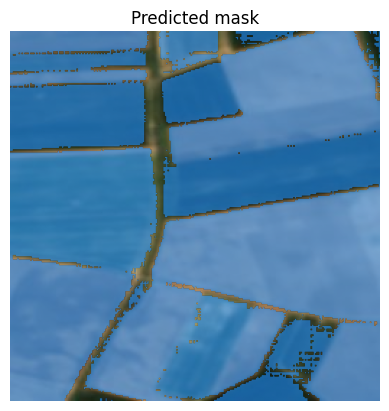

In [41]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(test_img))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

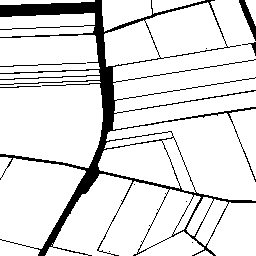

In [42]:
test_gt = Image.open(os.path.join(TEST, 'gt', ex))
fn = lambda x : 255 if x > 70 else 0
gt = test_gt.convert('L').point(fn, mode = '1')
gt

In [46]:
metrics.pixel_accuracy(medsam_seg, np.asarray(gt))

0.8948974609375

In [47]:
metrics.IoU(medsam_seg, np.asarray(gt))

0.8896701958962695

In [48]:
metrics.dice(medsam_seg, np.asarray(gt))

0.9445339174128712

In [16]:
import os
import numpy as np
import glob

In [1]:
train_values = [0.8967423691423397
,0.8142917764885806
,0.7850576169085036
,0.7671064562270424
,0.7543187745473672
,0.7434556474029436
,0.7340719803245526
,0.7254385797592056
,0.7170611318771148
,0.7088034369949409
,0.7005878379416777
,0.6958860959675685
,0.6864793940237951
,0.6821341465442693
,0.6760941582583255
,0.6696987676673876
,0.6633281629860207
,0.6577291013703284
,0.6518255192847128
,0.6465348916716801
,0.6403663016807178
,0.6357198018301582
,0.631898529148063
, 0.6239782390260541
,0.6221832673305021
,0.617754351104995
,0.6236171496771155
,0.6231027525646388
,0.5926560651911392
,0.5973272640682781
,0.5830112845312306
,0.590184193165178
,0.5854893178273397
,0.5713111765194284
,0.5712551489012997
,0.5690506172930102
,0.5706973064338928
, 0.5622053481348697
,0.5584846905126245
, 0.5603648138138487]

In [5]:
import seaborn as sns

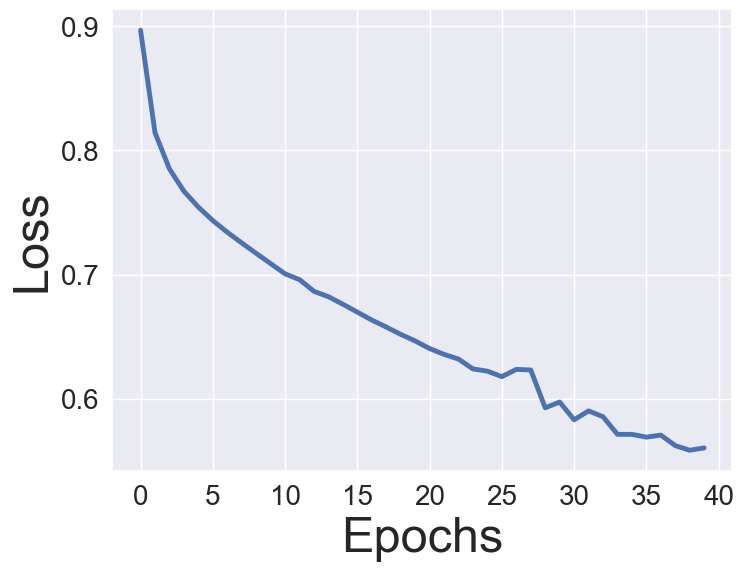

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.set(style='darkgrid')
sns.lineplot(train_values,  markers=True, linewidth = 3.5)

ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

plt.yticks(size = 20)
plt.xticks(size = 20)

plt.ylabel('Loss', size = 35)
plt.xlabel('Epochs', size = 35)


plt.show()